# test that FKM works and im not silly

In [28]:
import numpy as np

a = 3
c = 1

def f(x):
    return c * (x - a) ** 2

def d_f(x):
    return 2 * c * (x - a)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 325079.37it/s]


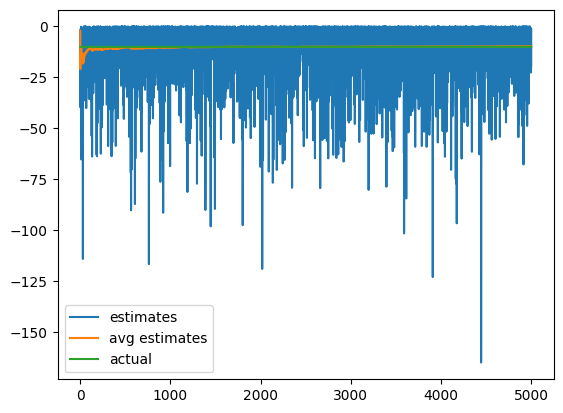

-10
-2.1656275059673367 -10.460191004031463 -9.984618980763113 -10.00470881460546 -9.843044281118233 -9.736823575275533


In [42]:
import matplotlib.pyplot as plt
import tqdm

x = -2
initial_scale = 0.9
T = 5000

estimates = []
actual = d_f(x)

for t in tqdm.trange(1, T + 1):
    scale = initial_scale / t ** 0.25
    noise = np.random.randn()
    grad = (f(x + noise * scale) - f(x)) * noise / scale
    estimates.append(grad)
avg_estimates = np.cumsum(estimates) / np.arange(1, T + 1)
plt.plot(range(T), estimates, label='estimates')
plt.plot(range(T), avg_estimates, label='avg estimates')
plt.plot(range(T), [actual for _ in range(T)], label='actual')
plt.legend()
plt.show()
print(actual)
print(*[avg_estimates[min(j * 1000, len(avg_estimates) - 1)] for j in range(len(avg_estimates) // 1000 + 1)])

# test that sys id works and im not silly

In [15]:
import numpy as np

delta = 0.
d = 9

A = 1 - delta
B = np.random.randn(d)

print('B = {}'.format(B))

def perturbation(t):
#     return 50 * np.sin(t)
    return np.random.randn()

def dynamics(state, control, t):
    return A * state + np.dot(B, control) + perturbation(t)

B = [-1.36687292  0.80621102  0.67607062  0.26855785 -0.70577285 -0.9346887
 -0.93421045  0.44094614  1.13392471]


In [16]:
T = 100000
prev_state = 0.
state = 0.  # x_0
scale = 2 # sigma

u = np.random.randn(d)
B_estimate = np.ones(d)

for t in range(1, T + 1):
    r = np.random.randn(d)
    control = u + scale * r
    state = dynamics(state, control, t)
    
    b_momentum = 1 - 1 / t
    B_estimate = b_momentum * B_estimate + (1 - b_momentum) * r * (state - prev_state) / scale
    
    prev_state = state
print(B_estimate)

[-1.37737397  0.81534405  0.6629152   0.26808228 -0.69609782 -0.93783003
 -0.90902589  0.43650577  1.12841694]


# world model before controller

In [272]:
p = torch.nn.Parameter(torch.tensor(2.))

for _ in range(5):
    f = torch.tensor(5)
    loss = ((p - f) ** 2).sum()
    loss.backward()
    print(p.grad)
    p.grad.zero_()

tensor(-6.)
tensor(-6.)
tensor(-6.)
tensor(-6.)
tensor(-6.)


In [370]:
from collections import deque
import torch                                                                                                                   

class WorldModel:
    def __init__(self, h, eta):
        self.h = h
        self.eta = eta
        
        self.wait = h
        
        # things to keep track of
        self.us = deque(maxlen=self.h)
        self.fs = deque(maxlen=self.h)
        self.f_accum = 0.
        self.t = 0
        
        # learnable parameters with which to predict f_t
        self.K = torch.nn.Parameter(torch.zeros(self.h))  # predicts from past f's (f_{t-1} to f_{t-h})
        self.Q = torch.nn.Parameter(torch.zeros(self.h))  # predicts from past u's (u_t to u_{t-h+1})
        self.N = torch.nn.Parameter(torch.zeros(1))  # predicts from f_bar := f_accum / t
        self.b = torch.nn.Parameter(torch.zeros(1))  # bias
        
        self.opt = torch.optim.Adam([self.K, self.Q, self.N, self.b], self.eta)
        pass
    
    def forward(self, u):
        us = torch.tensor([u, *self.us][:-1])
        fs = torch.tensor(self.fs)
        f_bar = self.f_accum / self.t
        
        pred = self.b + torch.dot(self.K, fs) + torch.dot(self.Q, us) + self.N * f_bar
        return pred
    
    def step(self, u, f):
        """
        i played u and received f
        """
        u = torch.FloatTensor([u])
        f = torch.FloatTensor([f])
        
        ret = None
        if self.t > self.wait:
            self.opt.zero_grad()
            pred = self.forward(u)
            loss = torch.nn.functional.mse_loss(pred, f)
            loss.backward()
            ret = pred.item()
            self.opt.step()
            
        self.us.appendleft(u)
        self.fs.appendleft(f)
        self.f_accum += f
        self.t += 1
        
        return ret

(0.0, 2.0)

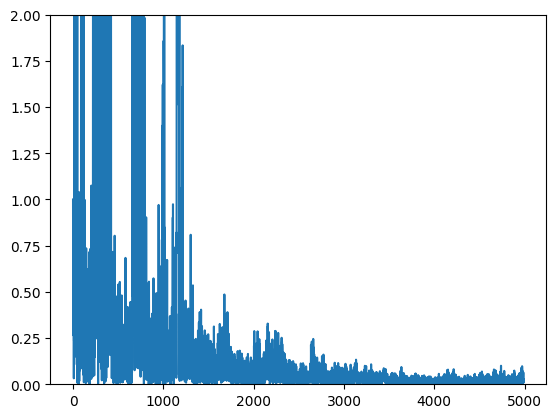

In [392]:
import numpy as np

# x_star = 2.
# scale = 1.

def func(x):
    return scale * (x - x_star) * (x - x_star)

# def d_func(x):
#     return scale * 2 * (x - x_star)

# def func(x):
#     return float(np.exp(-x) + np.log(x ** 2) - 5 * x)

x = 0.1
num_steps = 5000

w = WorldModel(5, 0.01)

losses = []
for t in range(num_steps):
    rand = np.random.randint(int(1 + t ** 0.025))
    u = np.sin(t * rand) * rand + np.random.randn() * 0.1
    x += u
    f = func(x)
    pred = w.step(u, f)
    if pred is not None: losses.append(abs(pred - f) / abs(f))

import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)
plt.ylim(0, 2)
        

